In [1]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from fgsm.deep_convnet import DeepConvNet
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from common.functions import softmax

Using TensorFlow backend.


In [2]:
### 画像データ読み込み、加工

# 画像の入っているフォルダを指定し、中身のファイル名を取得
filenames = sorted(os.listdir('../fgsm/handwrite_numbers'))

# フォルダ内の全画像をデータ化
img_test = np.empty((0, 784))
for filename in filenames:
    # 画像ファイルを取得、グレースケール（モノクロ）にしてサイズ変更
    img = Image.open('../fgsm/handwrite_numbers/' + filename).convert('L')
    resize_img = img.resize((784, 784))

    img_data256 = np.array([])
    for y in range(28):
        for x in range(28):
            # 1画素に縮小される範囲の明るさの二乗平均をとり、白黒反転
            # crop()は、画像の一部の領域を切り抜くメソッド。切り出す領域を引数(left, upper, right, lower)（要は左上と右下の座標）で指定する。
            crop = np.asarray(resize_img.crop((x * 28, y * 28, x * 28 + 28, y * 28 + 28)))
            bright = 255 - crop.mean()**2 / 255
            img_data256 = np.append(img_data256, bright)

    img_data = img_data256 / 255

    img_test = np.r_[img_test, img_data.reshape(1, -1)]

# 画像データの正解を配列にしておく
img_ans = []
for filename in filenames:
    img_ans += [int(filename[:1])]

img_ans = np.array(img_ans)

In [3]:
print("img_test.shape", img_test.shape)
print("img_ans.shape", img_ans.shape)

img_test.shape (30, 784)
img_ans.shape (30,)


In [4]:
img_ans_c = keras.utils.to_categorical(img_ans, 10)
print(img_ans_c.shape)

(30, 10)


In [5]:
# モデルを読み込む
model = model_from_json(open('../keras_sample/mnist_mlp_model.json').read())

# 学習結果を読み込む
model.load_weights('../keras_sample/mnist_mlp_weights.h5')

model.summary();

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

W1126 21:19:54.637745 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1126 21:19:54.657280 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1126 21:19:54.676835 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1126 21:19:54.678053 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehol

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [6]:
score = model.evaluate(img_test, img_ans_c, verbose=0)
# print('Test loss :', score[0])
print('handwritesに対するkerasの正答率：', score[1])

handwritesに対するkerasの正答率： 0.8333333134651184


In [7]:
network = DeepConvNet()

network.load_params("keras_clone_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [8]:
img_test28 = img_test.reshape(img_test.shape[0], 1, 28, 28)
print(img_test28.shape)

(30, 1, 28, 28)


In [9]:
test_acc = network.accuracy(img_test28, img_ans, batch_size=30)
print("handwritesに対するクローンの正答率：", test_acc)

handwritesに対するクローンの正答率： 0.9666666666666667


In [10]:
clone_pred = network.predict(img_test28)
clone_pred_label = np.argmax(clone_pred, axis=1)
clone_pred_score = list(map(lambda x:round(x, 2), np.max(softmax(clone_pred), axis=1)))

# 結果の出力
print("判定結果")
print("観測：", img_ans)
print("予測：", clone_pred_label)
# print("信頼度：", clone_pred_score
print("正答率：", np.sum(clone_pred_label == img_ans)/(img_test.shape[0]))


判定結果
観測： [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9]
予測： [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 9 8 8 8 9 9 9]
正答率： 0.9666666666666667


In [11]:
def generate_adv(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [12]:
def change_adv_list(x_list, t_list, network, eps):
    adv_list = []
    for x, t in zip(x_list, t_list):
        adv = generate_adv(x, t, network, eps)
        adv_list.append(adv.reshape(1, 28, 28))
        
    adv_list = np.array(adv_list)
    return adv_list

In [13]:
fgsm_test = change_adv_list(img_test28, img_ans, network, 0.3)
fgsm_test.shape

(30, 1, 28, 28)

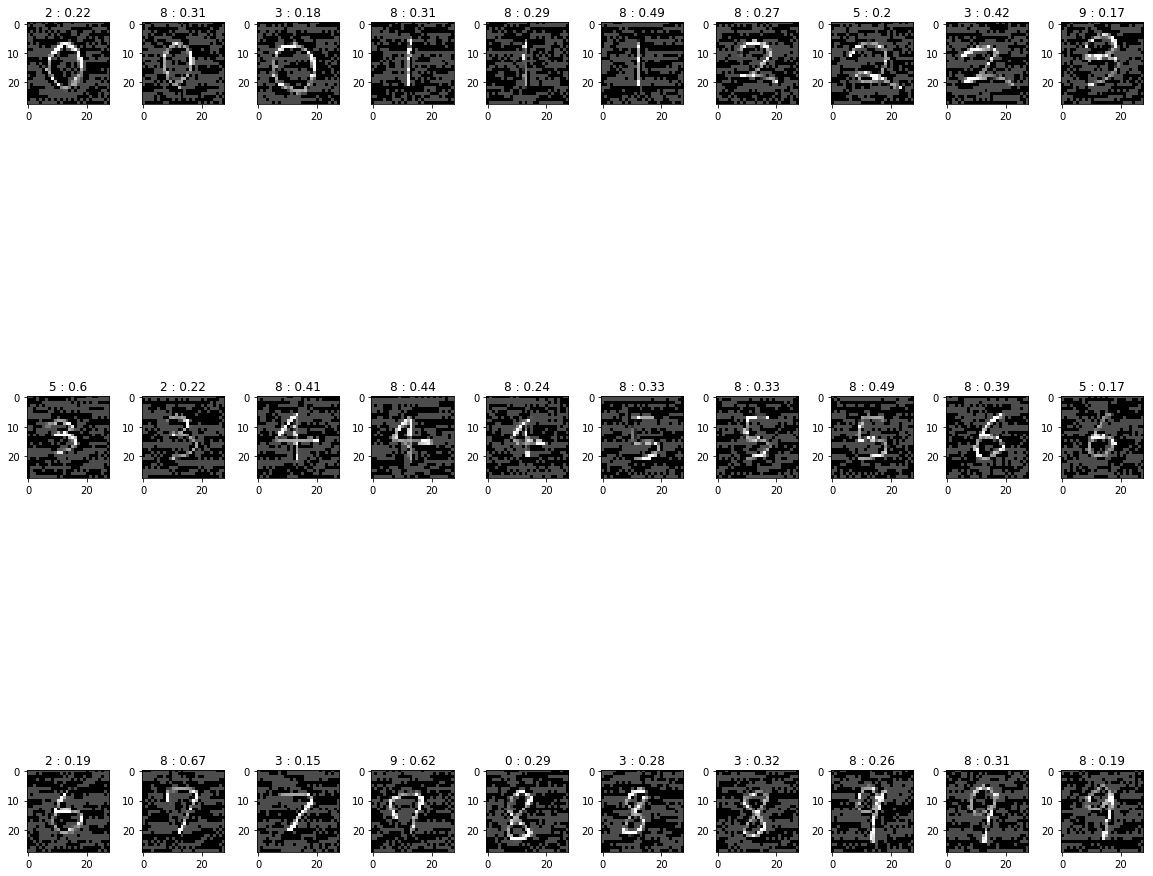

In [14]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0.4, hspace=0.1)
for i, f in enumerate(fgsm_test):
    f = f.reshape(1, 1, 28, 28)
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(f.reshape(28,28), 'gray')
    pre = network.predict(f)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    ax.set_title(f"{pre_label} : {pre_score}")
    
plt.show()

In [15]:
fgsm_clone_acc = network.accuracy(fgsm_test, img_ans, batch_size=32)
print("FGSMに対するクローンの正答率：", fgsm_clone_acc)

FGSMに対するクローンの正答率： 0.0


In [16]:
fgsm_clone_pred = network.predict(fgsm_test)
fgsm_clone_pred_label = np.argmax(fgsm_clone_pred, axis=1)
fgsm_clone_pred_score = list(map(lambda x:round(x, 2), np.max(softmax(fgsm_clone_pred), axis=1)))

# 結果の出力
print("判定結果")
print("観測：", img_ans)
print("予測：", fgsm_clone_pred_label)
# print("信頼度：", fgsm_clone_pred_score
print("正答率：", np.sum(fgsm_clone_pred_label == img_ans)/(img_test.shape[0]))


判定結果
観測： [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9]
予測： [2 8 3 8 8 8 8 5 3 9 5 2 8 8 8 8 8 8 8 5 2 8 3 9 0 3 3 8 8 8]
正答率： 0.0


In [17]:
FGSM_test = fgsm_test.reshape(fgsm_test.shape[0], 784)
fgsm_score = model.evaluate(FGSM_test, img_ans_c, verbose=0)
# print('Test loss :', score[0])
print('FGSMに対するkerasの正答率：', fgsm_score[1])

FGSMに対するkerasの正答率： 0.13333334028720856


In [18]:
network2 = DeepConvNet()

network2.load_params("../fgsm/deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [19]:
modela_acc = network2.accuracy(img_test28, img_ans, batch_size=30)
print("handwritesに対するモデルAの正答率：", modela_acc)

handwritesに対するモデルAの正答率： 1.0


In [20]:
modela_fgsm_test = change_adv_list(img_test28, img_ans, network2, 0.3)
modela_fgsm_test.shape

(30, 1, 28, 28)

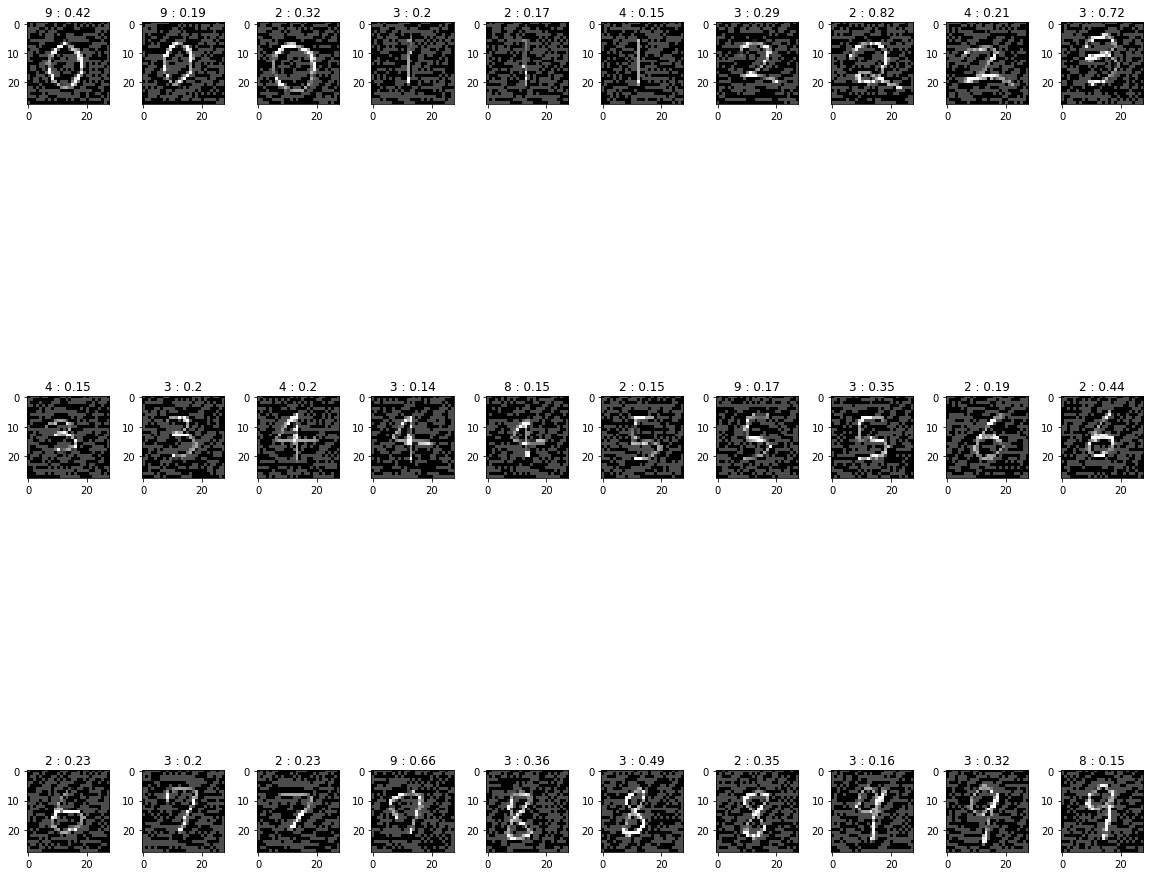

In [21]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0.4, hspace=0.1)
for i, f in enumerate(modela_fgsm_test):
    f = f.reshape(1, 1, 28, 28)
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(f.reshape(28,28), 'gray')
    pre = network2.predict(f)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    ax.set_title(f"{pre_label} : {pre_score}")
    
plt.show()

In [29]:
modela_fgsm_acc = network2.accuracy(modela_fgsm_test, img_ans, batch_size=30)
print("モデルAFGSMに対するモデルAの正答率：", modela_fgsm_acc)

モデルAFGSMに対するモデルAの正答率： 0.13333333333333333


In [30]:
modela_fgsm_pred = network2.predict(modela_fgsm_test)
modela_fgsm_pred_label = np.argmax(modela_fgsm_pred, axis=1)
modela_fgsm_pred_score = list(map(lambda x:round(x, 2), np.max(softmax(modela_fgsm_pred), axis=1)))

# 結果の出力
print("判定結果")
print("観測：", img_ans)
print("予測：", modela_fgsm_pred_label)
# print("信頼度：", modela_fgsm_pred_score
print("正答率：", np.sum(modela_fgsm_pred_label == img_ans)/(img_test.shape[0]))


判定結果
観測： [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9]
予測： [9 9 2 3 2 4 3 2 4 3 4 3 4 3 8 2 9 3 2 2 2 3 2 9 3 3 2 3 3 8]
正答率： 0.13333333333333333


In [31]:
modela_FGSM_test = modela_fgsm_test.reshape(modela_fgsm_test.shape[0], 784)
modela_fgsm_score = model.evaluate(modela_FGSM_test, img_ans_c, verbose=0)
# print('Test loss :', score[0])
print('モデルAFGSMに対するkerasの正答率：', modela_fgsm_score[1])

モデルAFGSMに対するkerasの正答率： 0.20000000298023224


In [32]:
modela_fgsm_clone_acc = network.accuracy(modela_fgsm_test, img_ans, batch_size=30)
print("モデルAFGSMに対するクローンの正答率：", modela_fgsm_clone_acc)

モデルAFGSMに対するクローンの正答率： 0.4


In [33]:
modela_fgsm_clone_pred = network.predict(modela_fgsm_test)
modela_fgsm_clone_pred_label = np.argmax(modela_fgsm_clone_pred, axis=1)
modela_fgsm_clone_pred_score = list(map(lambda x:round(x, 2), np.max(softmax(modela_fgsm_clone_pred), axis=1)))

# 結果の出力
print("判定結果")
print("観測：", img_ans)
print("予測：", modela_fgsm_clone_pred_label)
# print("信頼度：", modela_fgsm_clone_pred_score
print("正答率：", np.sum(modela_fgsm_clone_pred_label == img_ans)/(img_test.shape[0]))


判定結果
観測： [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8 9 9 9]
予測： [0 8 0 8 8 8 3 2 4 9 5 5 8 8 8 5 5 5 8 6 6 8 3 9 8 8 8 8 8 9]
正答率： 0.4
